In [ ]:
import pandas as pd
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_1_step/Papyrus/src/papyrus_scripts/reader.py"))
from tdc.multi_pred import DTI


# Papyrus

In [ ]:
#try:
    #import papyrus_scripts
#except:
    #!pip uninstall papyrus-scripts -y
    #!pip install rdkit-pypi
    #!pip install https://github.com/OlivierBeq/Papyrus-scripts/tarball/master --no-cache-dir
    #get_ipython().kernel.do_shutdown(True)
from papyrus_scripts.reader import read_papyrus, read_protein_set

### Extract drugs

In [41]:
sample_data = read_papyrus(is3d=False, chunksize=None, source_path=None)

### Extract Proteins


In [42]:
protein_data = read_protein_set(source_path=None)
protein_data.head()

,target_id,UniProtID,Status,Organism,Classification,Length,Sequence,TID
0,P47747_WT,HRH2_CAVPO,reviewed,Cavia porcellus (Guinea pig),Membrane receptor->Family A G protein-coupled ...,359,MAFNGTVPSFCMDFTVYKVTISVILIILILVTVAGNVVVCLAVGLN...,ChEMBL:CHEMBL2882
1,B0FL73_WT,B0FL73_CAVPO,unreviewed,Cavia porcellus (Guinea pig),Membrane receptor->Family A G protein-coupled ...,467,MGAGVLALGASEPCNLSSTAPLPDGAATAARLLVPASPPASLLPPT...,ChEMBL:CHEMBL5471
2,Q8K4Z4_WT,ADRB2_CAVPO,reviewed,Cavia porcellus (Guinea pig),Membrane receptor->Family A G protein-coupled ...,418,MGHLGNGSDFLLAPNASHAPDHNVTRERDEAWVVGMAIVMSLIVLA...,ChEMBL:CHEMBL5414
3,P97266_WT,OPRM_CAVPO,reviewed,Cavia porcellus (Guinea pig),Membrane receptor->Family A G protein-coupled ...,98,YTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGTILCK...,ChEMBL:CHEMBL4354;ChEMBL:CHEMBL2111465
4,P41144_WT,OPRK_CAVPO,reviewed,Cavia porcellus (Guinea pig),Membrane receptor->Family A G protein-coupled ...,380,MGRRRQGPAQPASELPARNACLLPNGSAWLPGWAEPDGNGSAGPQD...,ChEMBL:CHEMBL3952;ChEMBL:CHEMBL2111465


In [ ]:
sample_data.columns

### Merge drugs and proteins

In [ ]:
sample_data['TID'] = sample_data['TID'].astype(str) # TID is ID
protein_data['TID'] = protein_data['TID'].astype(str)

protein_data_exploded = protein_data.assign(TID=protein_data['TID'].str.split(';')).explode('TID')

sample_data = sample_data.merge(protein_data_exploded[['TID', 'Sequence']], on='TID', how='left')

print(sample_data.head())

In [44]:
sample_data = sample_data.dropna(subset=['Sequence'])

In [46]:
sample_data.to_csv("Papyrus_final.csv", index=False, encoding="utf-8")

### Barlow dataset 

In [12]:
import pandas as pd
dataset_path = "/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_final.csv"
train_df = pd.read_csv(dataset_path)
print(train_df.columns)

Index(['smiles', 'sequence', 'label', 'split'], dtype='object')


### Rename Columns

In [13]:
train_df.rename(columns={"SMILES": "smiles", "Sequence": "sequence", 'pchembl_value_Mean': 'label'}, inplace=True)
train_df.to_csv(dataset_path, index=False)


### Remove NaN

In [14]:
train_df = train_df.dropna(subset=['sequence'])
print(train_df.isnull().sum()) 

smiles      0
sequence    0
label       0
split       0
dtype: int64


In [15]:
colunas_para_manter = ["smiles", "sequence", 'label']
train_df = train_df[colunas_para_manter]


### Creat Split Column

In [16]:
import numpy as np
np.random.seed(42)
train_df["split"] = np.random.choice(["train", "val", "test"], size=len(train_df), p=[0.7, 0.15, 0.15])
train_df.to_csv(dataset_path, index=False)
print(train_df["split"].value_counts()) 

split
train    365868
test      78357
val       78215
Name: count, dtype: int64


Min: 9
Mean: 620.3358821863495
Max: 7096
95th percentile: 1390.0


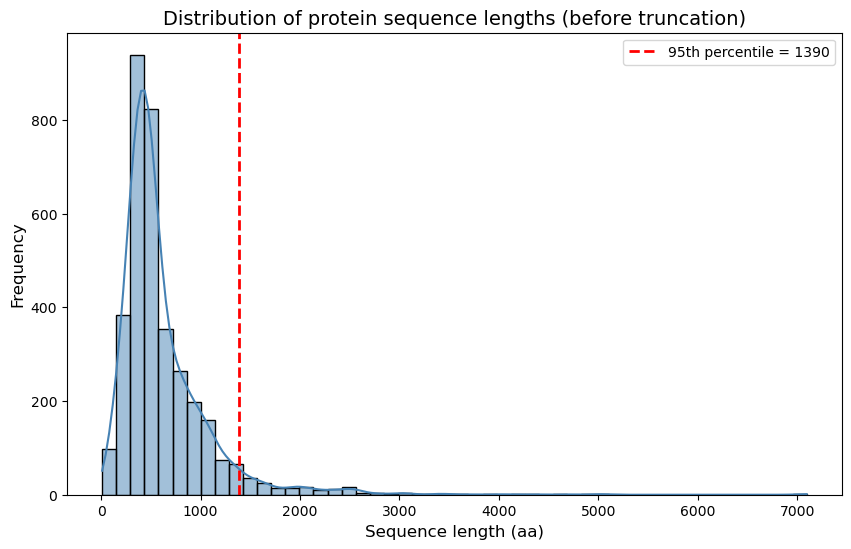

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# comprimentos ANTES da truncagem
unique_seqs = train_df['sequence'].unique()
seq_lengths = [len(seq) for seq in unique_seqs]

# estatísticas
print("Min:", np.min(seq_lengths))
print("Mean:", np.mean(seq_lengths))
print("Max:", np.max(seq_lengths))
print("95th percentile:", np.percentile(seq_lengths, 95))

# histograma
plt.figure(figsize=(10,6))
sns.histplot(seq_lengths, bins=50, kde=True, color="steelblue")
plt.axvline(np.percentile(seq_lengths, 95), color="red", linestyle="--", linewidth=2, 
            label=f"95th percentile = {int(np.percentile(seq_lengths, 95))}")

plt.title("Distribution of protein sequence lengths (before truncation)", fontsize=14)
plt.xlabel("Sequence length (aa)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()


Min: 12
Mean: 51.91600555023102
Max: 129
95th percentile: 76.0


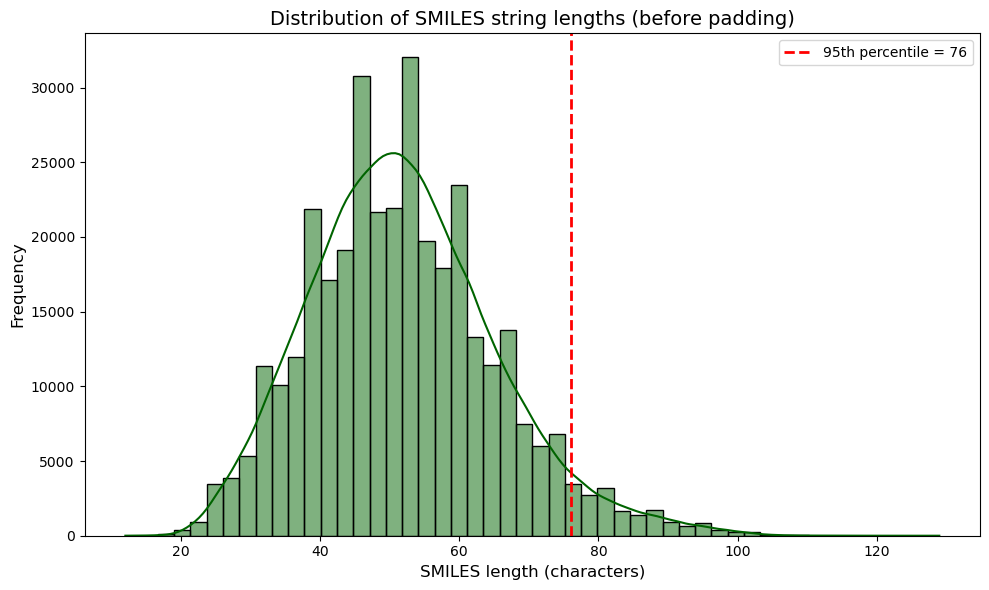

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# calcular comprimentos dos SMILES
unique_smiles = train_df['smiles'].unique()
smiles_lengths = [len(s) for s in unique_smiles]

# estatísticas
print("Min:", np.min(smiles_lengths))
print("Mean:", np.mean(smiles_lengths))
print("Max:", np.max(smiles_lengths))
print("95th percentile:", np.percentile(smiles_lengths, 95))

# percentil 95
threshold = np.percentile(smiles_lengths, 95)

# histograma
plt.figure(figsize=(10,6))
sns.histplot(smiles_lengths, bins=50, kde=True, color="darkgreen")
plt.axvline(threshold, color="red", linestyle="--", linewidth=2, 
            label=f"95th percentile = {int(threshold)}")

plt.title("Distribution of SMILES string lengths (before padding)", fontsize=14)
plt.xlabel("SMILES length (characters)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()


### Truncar

In [10]:
max_len = 1385

train_df['sequence'] = train_df['sequence'].apply(
    lambda seq: seq[:max_len] if len(seq) > max_len else seq
)


In [19]:
test_dataset_path = "/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv"
train_df.to_csv(test_dataset_path, index=False)


### Treshold

In [ ]:
threshold = 6.5
train_df["label"] = (train_df["label"] > threshold).astype(int)
train_df.to_csv("/home/resperanca/Tuberculosis_Tese/Papyrus_Barlow.csv", index=False)

In [ ]:
cont = train_df["label"].value_counts()
print(cont)

label
1    276003
0    246437
Name: count, dtype: int64


## Stratifying datasets: SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

#Dataset Barlow
 
df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Datasets/DTI_Data_2_step/Papyrus_Barlow.csv")

df = df.drop(columns=["split"]) 

# create train+temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],  
    random_state=42
)

#val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

#concat
df_stratified = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)
df_stratified.to_csv("/home/resperanca/Tuberculosis_Tese/Datasets/DTI_Data_2_step/Papyrus_Barlow.csv", index=False)


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

#Dataset TB for Barlow
df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Datasets/Tuberculosis_Data/tb_fina_BARLOW.csv")

df = df.drop(columns=["split"])  

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'], 
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

df_stratified = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

df_stratified.to_csv("/home/resperanca/Tuberculosis_Tese/Datasets/Tuberculosis_Data/tb_fina_BARLOW.csv", index=False)

# Davis

In [6]:
data_DAVIS= DTI(name = 'DAVIS')
DAVIS = data_DAVIS.get_data()

Found local copy...
Loading...
Done!


In [7]:
DAVIS.to_csv("DAVIS.csv", index=False, encoding="utf-8")

In [12]:
DAVIS


,Drug_ID,Drug,Target_ID,Target,Y
0,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,43.0
1,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,10000.0
2,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,10000.0
3,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,10000.0
4,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1B,MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTC...,10000.0
...,...,...,...,...,...
25767,151194,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,YES,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,10000.0
25768,151194,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,YSK1,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,10000.0
25769,151194,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,YSK4,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,1900.0
25770,151194,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,ZAK,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,4400.0


In [ ]:
unique_smiles_count = DAVIS["Drug"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")
unique_target_count = DAVIS["Target"].nunique()
print(f"Unique Targets: {unique_target_count}")

# KIBA

In [15]:
data_KIBA = DTI(name = 'KIBA')
KIBA = data_KIBA.get_data()

Found local copy...
Loading...
Done!


In [16]:
KIBA

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O00141,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O15111,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000
...,...,...,...,...,...
117652,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13554,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794
117653,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13555,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794
117654,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13557,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794
117655,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q16539,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794


In [ ]:
unique_smiles_count = KIBA["Drug"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")

In [ ]:
unique_target_count = KIBA["Target"].nunique()
print(f"Unique Targets: {unique_target_count}")

# BindingDB

In [19]:
dataBD_KD = DTI(name = 'BindingDB_Kd')
BD_KD = dataBD_KD.get_data()

Found local copy...
Loading...
Done!


In [20]:
BD_KD

,Drug_ID,Drug,Target_ID,Target,Y
0,444607.0,Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.460
1,4316.0,COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.490
2,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.830
3,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.200
4,1612.0,COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.160
...,...,...,...,...,...
52269,53358942.0,COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.150
52270,53476877.0,CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2CC[C@H](O)...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,2.700
52271,58573469.0,CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.045
52272,113557.0,CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,17.000


In [ ]:
unique_smiles_count = BD_KD["Drug_ID"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")
unique_target_count = BD_KD["Target"].nunique()
print(f"Unique Targets: {unique_target_count}")

In [22]:
dataBD_IC50 = DTI(name = 'BindingDB_IC50')
BD_IC50 = dataBD_IC50.get_data()


Found local copy...
Loading...
Done!


In [23]:
BD_IC50

,Drug_ID,Drug,Target_ID,Target,Y
0,71463198.0,Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...,P08684,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,50000.0
1,44640149.0,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,P51570,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,6676.9
2,65023.0,CC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C...,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,8.5
3,461984.0,CCOC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@@H](O...,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,177.0
4,461988.0,COCCOC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@@H]...,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,164.0
...,...,...,...,...,...
990625,76336413.0,COc1ccc2c(c1)oc1cccc(CNCc3ccccc3)c12,P81908,EEDIIITTKNGKVRGMNLPVLGGTVTAFLGIPYAQPPLGRLRFKKP...,18100.0
990626,76311049.0,CC(C)NCc1cccc2oc3cc(O)ccc3c12,P81908,EEDIIITTKNGKVRGMNLPVLGGTVTAFLGIPYAQPPLGRLRFKKP...,18360.0
990627,76321936.0,COc1ccc2c(c1)oc1cccc(CN(C(=O)CCO[N+](=O)[O-])C...,P81908,EEDIIITTKNGKVRGMNLPVLGGTVTAFLGIPYAQPPLGRLRFKKP...,14300.0
990628,76329133.0,COc1ccc2c(c1)[nH]c1cccc(CNC(C)C)c12,P81908,EEDIIITTKNGKVRGMNLPVLGGTVTAFLGIPYAQPPLGRLRFKKP...,10080.0


In [ ]:
unique_smiles_count = BD_IC50["Drug_ID"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")
unique_target_count = BD_IC50["Target"].nunique()
print(f"Unique Targets: {unique_target_count}")

In [25]:
dataBD_KI = DTI(name = 'BindingDB_Ki')
BD_KI = dataBD_KI.get_data()

Found local copy...
Loading...
Done!


In [ ]:
BD_KI

In [ ]:
unique_smiles_count = BD_KI["Drug_ID"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")
unique_target_count = BD_KI["Target"].nunique()
print(f"Unique Targets: {unique_target_count}")

# Metz

In [ ]:
import pandas as pd

file_path = "/home/resperanca/Tuberculosis Tese/data/Metz.csv"
METZ = pd.read_csv(file_path)
print(METZ.shape[0])
print(METZ.columns)

In [ ]:
unique_smiles_count = METZ["SMILES"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")

In [ ]:
unique_smiles_count = METZ["ProteinSequence"].nunique()
print(f"Unique Targets: {unique_smiles_count}")

# Human


In [ ]:
file_path = "/home/resperanca/Tuberculosis Tese/data/Human.csv"
df_Human = pd.read_csv(file_path)
print(df_Human.shape[0])
print(df_Human.columns)

In [ ]:
unique_smiles_count = df_Human["compound_iso_smiles"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")
unique_target_count = df_Human["target_sequence"].nunique()
print(f"Unique Targets: {unique_target_count}")

# C. elegans

In [ ]:
file_path = "/home/resperanca/Tuberculosis Tese/data/C_elegans.csv"
df_elangs = pd.read_csv(file_path)
print(df_elangs.shape[0])
print(df_elangs.columns)

In [ ]:
unique_smiles_count = df_elangs["smile"].nunique()
print(f"Unique SMILES: {unique_smiles_count}")
unique_target_count = df_elangs["protein"].nunique()
print(f"Unique Targets: {unique_target_count}")

# 